In [1]:
#Preparations
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import warnings


#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.precision', 2)

#import the dataset
df = pd.read_csv('metadata.csv', low_memory=False, thousands=',')

# Fix some entires
df['Domestic Box Office'] = df['Domestic Box Office'].fillna(0)
df['International Box Office'] = df['International Box Office'].fillna(0)
df['Worldwide Box Office'] = df['Worldwide Box Office'].fillna(0)

df['Revenue'] = np.maximum(df['Domestic Box Office'] + df['International Box Office'], df['Worldwide Box Office'])
for index, row in df.iterrows():
    if pd.isna(row['Leading Cast']):
        df.at[index, 'Leading Cast'] = df.at[index, 'Lead Ensemble Members']
        
        # Subsetting rows with both Budget and Revenue
df_sub = df.loc[(df['Revenue'] != 0) & (df['Budget'] != 0)].copy()
# Compute ROI
df_sub['ROI'] = (df_sub['Revenue']-df_sub['Budget'])/df_sub['Budget']*100

In [2]:
mon = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
dom_rel_month = pd.Series([])
for index, row in df_sub['Domestic Release'].to_frame().iterrows():
    d = ""
    if not pd.isna(row[0]):
        d = re.findall(r"([a-zA-Z]+)", row[0])
        if d != [] and d[0] in mon:
            t = d[0]
        else:
            t = np.nan
    else: 
        t = np.nan
    with warnings.catch_warnings():
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        dom_rel_month = dom_rel_month.append(pd.Series(data = t))

C:\Users\kongw\AppData\Local\Temp\ipykernel_9764\3740225237.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dom_rel_month = pd.Series([])


In [3]:
int_rel_month = pd.Series([])
for index, row in df_sub['International Release'].to_frame().iterrows():
    d = ""
    if not pd.isna(row[0]):
        d = re.findall(r"([a-zA-Z]+)", row[0])
        if d != [] and d[0] in mon:
            t = d[0]
        else:
            t = np.nan
    else: 
        t = np.nan
    with warnings.catch_warnings():
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        int_rel_month = int_rel_month.append(pd.Series(data = t))

C:\Users\kongw\AppData\Local\Temp\ipykernel_9764\3402644605.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  int_rel_month = pd.Series([])


In [4]:
df_sub['int_rel_month'] = int_rel_month.to_list()
df_sub['dom_rel_month'] = dom_rel_month.to_list()
df_sub['Year'] = ''
df_sub['Month'] = ''

from datetime import datetime

for index, row in df_sub.iterrows():
    if pd.isna(row['Dom Year']):
        df_sub.at[index, 'Year'] = row['Int Year']
        df_sub.at[index, 'Month'] = row['int_rel_month']
    else: 
        # dom year not na
        if pd.isna(row['Int Year']):
            df_sub.at[index, 'Year'] = row['Dom Year']
            df_sub.at[index, 'Month'] = row['dom_rel_month']
        else:
            #both year not na
            if row['Dom Year'] == row['Int Year']:
                df_sub.at[index, 'Year'] = row['Dom Year']
                # month
                if pd.isna(row['int_rel_month']):
                    df_sub.at[index, 'Month'] = row['dom_rel_month']
                elif pd.isna(row['dom_rel_month']):
                    df_sub.at[index, 'Month'] = row['int_rel_month']
                else:
                    #compare month
                    i = datetime.strptime(row['int_rel_month'], '%B').month
                    d = datetime.strptime(row['dom_rel_month'], '%B').month
                    if i <= d:
                        df_sub.at[index, 'Month'] = row['int_rel_month']
                    else:
                        df_sub.at[index, 'Month'] = row['dom_rel_month']
            elif row['Dom Year'] < row['Int Year']:
                df_sub.at[index, 'Year'] = row['Dom Year']
                df_sub.at[index, 'Month'] = row['dom_rel_month']
            else: 
                df_sub.at[index, 'Year'] = row['Int Year']
                df_sub.at[index, 'Month'] = row['int_rel_month']

In [5]:
df_sub['is_Franchise'] = np.where(pd.isna(df_sub['Franchise']), False, True)

In [6]:
dataset = df_sub[['moviename', 'Budget', 'Revenue', 'ROI', 'Year', 'Month',
            'Rating', 'Franchise', 'is_Franchise', 'Keywords', 'Genre', 'Production Method',
            'Creative Type', 'Production/Financing Companies', 'Leading Cast', 'Director']].copy()
dataset = dataset[~dataset['Year'].isna()]
dataset = dataset.loc[dataset['ROI'] < 50000]
dataset = dataset.loc[dataset['ROI'] > -95]

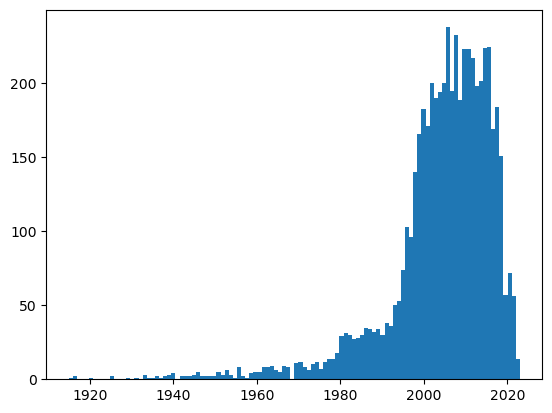

In [237]:
plt.hist(dataset['Year'].astype('int'), bins = 110)
plt.show()

In [11]:
dataset.shape

(5571, 16)

In [13]:
sum(dataset['Year'] > 1980)

5275

In [ ]:
# We only consider movies after 1980 for our prediction problem:

### Consider Time Windows:

In [143]:
# length of time window (in years)
# for example: if timewindoe = 3, then for year 2020, 
# we consider year 2016, 2017, 2018
timewindow_actor = 3
timewindow_director = 3
timewindow_genre = 3
# number of stars we consider for each time period
star_actor_num = 10
# number of directors we consider for each time period
star_director_num = 5

In [88]:
import ast
dataset['Leading Cast'] = dataset['Leading Cast'].fillna('[]').apply(ast.literal_eval)
dataset['Director'] = dataset['Director'].fillna('[]').apply(ast.literal_eval)

In [186]:
def castinfo(timewindow_actor, star_actor_num):
    cast_table = pd.DataFrame()

    for y in range(1980, 2024, 1):
        # get reference set for movie to be released in year y 
        subset = dataset.loc[dataset['Year'] <= y - 2].copy()
        subset = subset.loc[subset['Year'] > y - 2 - timewindow_actor].copy()

        # create table of total revenue of all actors in the past timewindow
        cast_year = pd.DataFrame(columns = ['name', 'year', 'Total Revenue', 'Star Actor'])
        for index, row in subset.iterrows():
            lead = row['Leading Cast']
            if lead != []:
                for name in lead:
                    if name in cast_year['name'].values:
                        rownum = np.where(cast_year['name'] == name)[0][0]
                        cast_year.at[rownum, 'Total Revenue'] = cast_year.at[rownum, 'Total Revenue'] + row['Revenue']
                    else:
                        cast_year.loc[len(cast_year)] = [name, y, row['Revenue'], False]

        # Find stars in this timewindow
        topactor = cast_year.sort_values(by = ['Total Revenue'], ascending = False)['name'].head(star_actor_num).reset_index(drop = True)
        for name in topactor:
            rownum = np.where(cast_year['name'] == name)[0][0]
            cast_year.at[rownum, 'Star Actor'] = True

        # Append to the main table
        cast_table = pd.concat([cast_table, cast_year], ignore_index = True)

    # Create two new features
    dataset['has_star_actor'] = False
    dataset['actor_revenue_before'] = 0
    for index, row in dataset.iterrows():
        lead = row['Leading Cast']
        if lead != []:
            temp = cast_table.loc[cast_table['year'] == row['Year']].copy()
            star_of_year = temp.loc[temp['Star Actor']]['name'].values
            namelist = temp['name'].values
            for name in lead:
                if name in star_of_year:
                    dataset.at[index, 'has_star_actor'] = True
                if name in namelist:
                    dataset.at[index, 'actor_revenue_before'] = dataset.at[index, 'actor_revenue_before'] + temp.loc[temp['name'] == name]['Total Revenue'].values[0]

### Do the same for directors:

In [189]:
def directorinfo(timewindow_director, star_director_num):
    director_table = pd.DataFrame()

    for y in range(1980, 2024, 1):
        # get reference set for movie to be released in year y 
        subset = dataset.loc[dataset['Year'] <= y - 2].copy()
        subset = subset.loc[subset['Year'] > y - 2 - timewindow_director].copy()

        # create table of total revenue of all directors in the past timewindow
        director_year = pd.DataFrame(columns = ['name', 'year', 'Total Revenue', 'Star Director'])
        for index, row in subset.iterrows():
            lead = row['Director']
            if lead != []:
                for name in lead:
                    if name in director_year['name'].values:
                        rownum = np.where(director_year['name'] == name)[0][0]
                        director_year.at[rownum, 'Total Revenue'] = director_year.at[rownum, 'Total Revenue'] + row['Revenue']
                    else:
                        director_year.loc[len(director_year)] = [name, y, row['Revenue'], False]

        # Find stars in this timewindow
        topdirector = director_year.sort_values(by = ['Total Revenue'], ascending = False)['name'].head(star_director_num).reset_index(drop = True)
        for name in topdirector:
            rownum = np.where(director_year['name'] == name)[0][0]
            director_year.at[rownum, 'Star Director'] = True

        # Append to the main table
        director_table = pd.concat([director_table, director_year], ignore_index = True)

    # Create two new features
    dataset['has_star_director'] = False
    dataset['director_revenue_before'] = 0
    for index, row in dataset.iterrows():
        lead = row['Director']
        if lead != []:
            temp = director_table.loc[director_table['year'] == row['Year']].copy()
            star_of_year = temp.loc[temp['Star Director']]['name'].values
            namelist = temp['name'].values
            for name in lead:
                if name in star_of_year:
                    dataset.at[index, 'has_star_director'] = True
                if name in namelist:
                    dataset.at[index, 'director_revenue_before'] = dataset.at[index, 'director_revenue_before'] + temp.loc[temp['name'] == name]['Total Revenue'].values[0]

### Genre

In [190]:
def genreinfo(timewindow_genre):
    genre_table = pd.DataFrame()

    for y in range(1980, 2024, 1):
        # get reference set for movie to be released in year y 
        subset = dataset.loc[dataset['Year'] <= y - 2].copy()
        subset = subset.loc[subset['Year'] > y - 2 - timewindow_genre].copy()

        # create table of total revenue of all actors in the past timewindow
        genre_year = pd.DataFrame(columns = ['genre', 'year', 'Total Revenue'])
        for index, row in subset.iterrows():
            g = row['Genre']
            if pd.notna(g):
                if g in genre_year['genre'].values:
                    rownum = np.where(genre_year['genre'] == g)[0][0]
                    genre_year.at[rownum, 'Total Revenue'] = genre_year.at[rownum, 'Total Revenue'] + row['Revenue']
                else:
                    genre_year.loc[len(genre_year)] = [g, y, row['Revenue']]

        genre_table = pd.concat([genre_table, genre_year], ignore_index = True)       

    dataset['genre_revenue_before'] = 0
    for index, row in dataset.iterrows():
        g = row['Genre']
        temp = genre_table.loc[genre_table['year'] == row['Year']].copy()
        genrelist = temp['genre'].values
        if pd.notna(g):
            if g in genrelist:
                dataset.at[index, 'genre_revenue_before'] = temp.loc[temp['genre'] == g]['Total Revenue'].values[0]
            else:
                dataset.at[index, 'genre_revenue_before'] = 0

### Model

In [441]:
dataset.head(10)

,moviename,Budget,Revenue,ROI,Year,Month,Rating,Franchise,is_Franchise,Keywords,Genre,Production Method,Creative Type,Production/Financing Companies,Leading Cast,Director,has_star_actor,actor_revenue_before,has_star_director,director_revenue_before,hit,genre_revenue_before
0,The Super Mario Bros. Movie,100000000,"509,221,843.00",409.22,"2,023.00",April,PG,NaN,False,"['Ensemble', 'Prince/Princess', 'Royalty', 'Go...",Action,Digital Animation,Kids Fiction,"['Universal Pictures', 'Nintendo', 'Illuminati...","[Chris Pratt, Anya Taylor-Joy, Charlie Day, Ja...","[Aaron Horvath, Michael Jelenic]",True,14305072670,False,51620593,Hits,39962497649
1,Harry Potter and the Chamber of Secrets,100000000,"874,954,530.00",774.95,"2,002.00",November,PG,['Harry Potter'],True,"['Boarding School', 'IMAX: DMR']",Adventure,Animation/Live Action,Fantasy,"['Warner Bros.', 'Heyday Films', '1492 Pictures']","[Daniel Radcliffe, Rupert Grint, Emma Watson, ...",[Chris Columbus],False,191035966,False,606160905,Hits,12102381328
2,Rudderless,5000000,"584,499.00",-88.31,"2,014.00",October,R,NaN,False,"['Death of a Son or Daughter', 'Singers', 'Mus...",Drama,Live Action,Contemporary Fiction,"['Unified Pictures', 'Dog Pond']","[Billy Crudup, Anton Yelchin]",[William H. Macy],False,623360822,False,0,Loss,16060988973
7,Mientras duermes,5000000,"9,109,597.00",82.19,"2,012.00",May,Not Rated,NaN,False,"['Home Invasion', 'Mental Illness', 'Fired', '...",Thriller/Suspense,Live Action,Contemporary Fiction,"['Filmax Entertainment', 'Castelao Produccione...","[Luis Tosar, Marta Etura]",[Jaume Balaguero],False,0,False,57676027,Below average,9275043679
9,Palm Springs,5000000,"1,818,417.00",-63.63,"2,020.00",July,R,NaN,False,['Sundance Film Festival 2020'],Comedy,Live Action,Contemporary Fiction,"['Limelight', 'Hulu', 'Sun Entertainment Cultu...","[Andy Samberg, Cristin Milioti]",[Max Barbakow],False,1900116196,False,0,Loss,9566585567
32,Every Day,4900000,"12,826,031.00",161.76,"2,018.00",February,PG-13,NaN,False,"['Romance', 'Body Swap', 'Same Role, Multiple ...",Drama,Live Action,Contemporary Fiction,"['Likely Story', 'Filmwave', 'Orion Pictures',...","[Angourie Rice, Justice Smith]",[Michael Sucsy],False,59596747,False,197618160,Above average,15331828406
33,Mommy,4900000,"17,536,004.00",257.88,"2,014.00",November,R,NaN,False,"['Widow/Widower', 'Single Parent', 'Death of a...",Drama,Live Action,Contemporary Fiction,"['Metafilms', 'Sons of Manuel']","[Suzanne Clement, Antoine Olivier Pilon]",[Xavier Dolan],False,0,False,0,Above average,16060988973
34,Obsluhoval jsem anglického krále,4900000,"7,174,984.00",46.43,"2,008.00",August,R,NaN,False,['Foreign Language'],Black Comedy,Live Action,Historical Fiction,NaN,[],[],False,0,False,0,Below average,388023564
35,Soul Kitchen,4900000,"23,347,461.00",376.48,"2,010.00",April,Not Rated,NaN,False,NaN,NaN,NaN,NaN,NaN,[],[],False,0,False,0,Hits,0
36,The Awakening,4900000,"6,924,321.00",41.31,"2,012.00",August,R,NaN,False,"['Paranormal Investigation', 'Boarding School'...",Horror,Live Action,Fantasy,"['Optimum Releasing', 'BBC Films', 'StudioCana...","[Rebecca Hall, Dominic West, Imelda Staunton]",[Nick Murphy],False,183872150,False,0,Below average,5589183592


In [442]:
dataset['hit'].value_counts()

Loss             1606
Hits             1393
Above average    1393
Below average    1179
Name: hit, dtype: int64

In [191]:
dataset['hit'] = ''
for index, row in dataset.iterrows():
    if row['ROI'] <= 0:
        dataset.at[index, 'hit'] = 'Loss'
    elif row['ROI'] > 0 and row['ROI'] <= 106.71:
        dataset.at[index, 'hit'] = 'Below average'
    elif row['ROI'] > 106.71 and row['ROI'] <= 320.26:
        dataset.at[index, 'hit'] = 'Above average'
    elif row['ROI'] > 320.26:
        dataset.at[index, 'hit'] = 'Hits'

In [192]:
final = dataset.loc[dataset['Year'] >= 1980].copy()
X = final[['Budget', 'Year', 'Month',
       'Rating', 'is_Franchise', 'Production Method',
       'Creative Type', 'has_star_actor', 'has_star_director',
       'actor_revenue_before', 'director_revenue_before',
        'genre_revenue_before']].copy()
X["Month"] = X["Month"].astype("category")
X["Rating"] = X["Rating"].astype("category")
X["is_Franchise"] = X["is_Franchise"].astype("category")
# X["Genre"] = X["Genre"].astype("category")
X["Production Method"] = X["Production Method"].astype("category")
X["Creative Type"] = X["Creative Type"].astype("category")
X["Year"] = X["Year"].astype('Int64')

X["has_star_actor"] = X["has_star_actor"].astype("category")
X["has_star_director"] = X["has_star_director"].astype("category")

accuracy score:  0.36757775683317623
MCC:  0.14999605286956


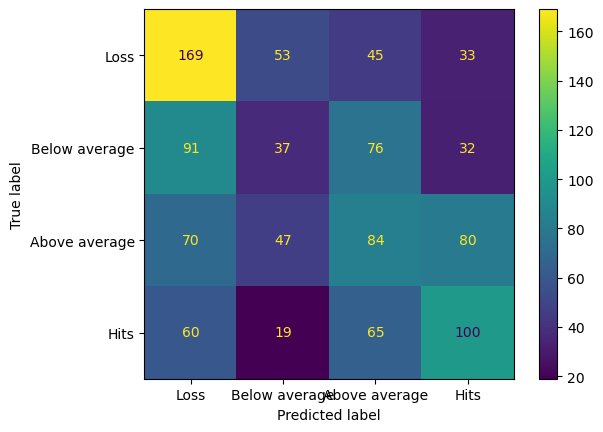

In [284]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    final[['hit']], test_size = .2, random_state = 10) #split the data

classes = {
    "Classes": [
        "Loss",
        "Below average",
        "Above average",
        "Hits",
    ]
}
df_classes = pd.DataFrame(data = classes)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(classes['Classes'])
y_train = le.fit_transform(y_train.values.ravel())

import xgboost as xgb
clf = xgb.XGBClassifier(enable_categorical = True,  
                      tree_method = "hist")
clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = clf.predict(X_test)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred, labels = classes['Classes'])
from sklearn.metrics import matthews_corrcoef
print("accuracy score: ", accuracy_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = classes['Classes'])
disp.plot()
plt.show()

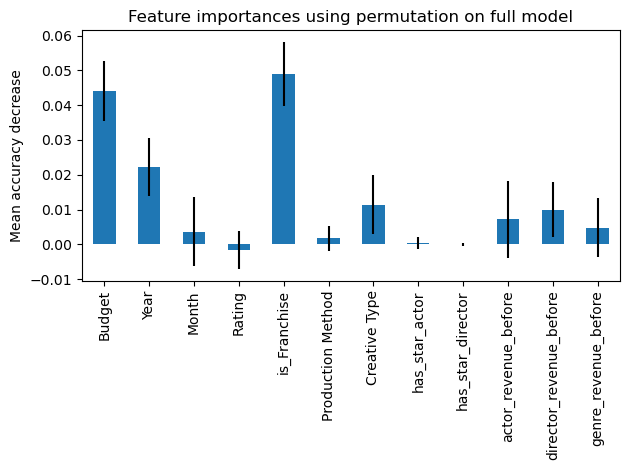

In [187]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    clf, X_test, le.fit_transform(y_test.values.ravel()), n_repeats=10, random_state=10, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index = list(X_train.columns.values))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [277]:
my_super_search = pd.DataFrame(columns = ["timewindow_actor",
                                          "timewindow_director",
                                          "timewindow_genre",
                                          "star_actor_num",
                                          "star_director_num",
                                          "params",
                                          "MCC"])

import itertools
tuning_list = {
    "timewindow_actor": [3, 5, 10],
    "timewindow_director": [3, 5, 10],
    "timewindow_genre": [3, 5, 10],
    "star_actor_num": [3, 5, 10],
    "star_director_num": [3, 5, 10],
    }
tuning_grid = list(itertools.product(*tuning_list.values()))

from tqdm import tqdm   
for s in tqdm(tuning_grid):
    timewindow_actor = s[0]
    timewindow_director = s[1]
    timewindow_genre = s[2]
    star_actor_num = s[3]
    star_director_num = s[4]
    
    castinfo(timewindow_actor, star_actor_num)
    directorinfo(timewindow_director, star_director_num)
    genreinfo(timewindow_genre)
    
    final = dataset.loc[dataset['Year'] >= 1980].copy()
    X = final[['Budget', 'Year', 'Month',
           'Rating', 'is_Franchise', 'Production Method',
           'Creative Type', 'has_star_actor', 'has_star_director',
           'actor_revenue_before', 'director_revenue_before',
            'genre_revenue_before']].copy()
    X["Month"] = X["Month"].astype("category")
    X["Rating"] = X["Rating"].astype("category")
    X["is_Franchise"] = X["is_Franchise"].astype("category")
    # X["Genre"] = X["Genre"].astype("category")
    X["Production Method"] = X["Production Method"].astype("category")
    X["Creative Type"] = X["Creative Type"].astype("category")
    X["Year"] = X["Year"].astype('Int64')

    X["has_star_actor"] = X["has_star_actor"].astype("category")
    X["has_star_director"] = X["has_star_director"].astype("category")
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    Y = le.fit_transform(final['hit'].values)

    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    estimator = XGBClassifier(
        enable_categorical = True,
        tree_method = "hist",
        seed = 42,
        eval_metric = matthews_corrcoef,
        n_estimators = 100
    )
    parameters = {
        'max_depth': range (3, 15, 3),
        'learning_rate': [0.01, 0.05, 0.1]
    }
    grid_search = GridSearchCV(
        estimator = estimator,
        param_grid = parameters,
        scoring = make_scorer(matthews_corrcoef),
        n_jobs = -1,
        cv = 5,
        return_train_score = True
    )
    grid_search.fit(X, Y)
    
    my_super_search.loc[len(my_super_search)] = list(s) + [grid_search.best_params_, grid_search.best_score_]


100%|██████████| 243/243 [7:33:08<00:00, 111.89s/it]  


In [285]:
my_super_search['MCC'].describe()

count   243.00
mean      0.03
std       0.01
min       0.02
25%       0.02
50%       0.03
75%       0.03
max       0.04
Name: MCC, dtype: float64

In [290]:
    from xgboost import XGBClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    estimator = XGBClassifier(
        enable_categorical = True,
        tree_method = "hist",
        seed = 42,
        n_estimators = 100
    )
    parameters = {
        'max_depth': range (3, 15, 3),
        'learning_rate': [0.01, 0.05, 0.1]
    }
    grid_search = GridSearchCV(
        estimator = estimator,
        param_grid = parameters,
        scoring = make_scorer(matthews_corrcoef),
        n_jobs = -1,
        cv = 5,
        return_train_score = True
    )
    grid_search.fit(X, Y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': range(3, 15, 3)},
             return_train_score=True, scoring=make_scorer(matthews_corrcoef))

In [291]:
grid_search.best_score_

0.020513469626041593

In [292]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 3}

In [293]:
grid_search.cv_results_

{'mean_fit_time': array([0.53079462, 1.39259853, 3.48420038, 6.54983368, 0.51255503,
        1.23480105, 2.99720097, 6.09209919, 0.64240255, 1.49805417,
        3.20100226, 4.25945449]),
 'std_fit_time': array([0.01724452, 0.10031391, 0.31154663, 0.43914852, 0.01240012,
        0.08350206, 0.27618684, 0.72325808, 0.08410351, 0.09963524,
        0.15378599, 0.31549126]),
 'mean_score_time': array([0.02620077, 0.04240088, 0.05480208, 0.07520161, 0.03020101,
        0.04300284, 0.06780877, 0.0912003 , 0.0365994 , 0.05379806,
        0.07559881, 0.06380758]),
 'std_score_time': array([0.00159979, 0.0061506 , 0.00711012, 0.01375866, 0.00248058,
        0.00419477, 0.02027838, 0.02188721, 0.00173913, 0.00426253,
        0.00835924, 0.00843773]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.01, 0.05, 0.05, 0.05, 0.05, 0.1,
                    0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, F

In [440]:
import itertools
tuning_list = {
    "timewindow_actor": [3, 5, 10],
    "timewindow_director": [3, 5, 10],
    "timewindow_genre": [3, 5, 10],
    "star_actor_num": [3, 5, 10],
    "star_director_num": [3, 5],
    }
tuning_grid = list(itertools.product(*tuning_list.values()))

from tqdm import tqdm   
for s in tqdm(tuning_grid):
    timewindow_actor = s[0]
    timewindow_director = s[1]
    timewindow_genre = s[2]
    star_actor_num = s[3]
    star_director_num = s[4] 


    castinfo(timewindow_actor, star_actor_num)
    directorinfo(timewindow_director, star_director_num)
    genreinfo(timewindow_genre)

    final = dataset.loc[dataset['Year'] >= 1980].copy()
    X = final[['Budget', 'Year', 'Month',
           'Rating', 'is_Franchise', 'Production Method',
           'Creative Type', 'has_star_actor', 'has_star_director',
           'actor_revenue_before', 'director_revenue_before',
            'genre_revenue_before']].copy()
    X["Month"] = X["Month"].astype("category")
    X["Rating"] = X["Rating"].astype("category")
    X["is_Franchise"] = X["is_Franchise"].astype("category")
    # X["Genre"] = X["Genre"].astype("category")
    X["Production Method"] = X["Production Method"].astype("category")
    X["Creative Type"] = X["Creative Type"].astype("category")
    X["Year"] = X["Year"].astype('Int64')

    X["has_star_actor"] = X["has_star_actor"].astype("category")
    X["has_star_director"] = X["has_star_director"].astype("category")

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    Y = le.fit_transform(final['hit'].values)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        final[['hit']], test_size = .2, random_state = 10) #split the data

    classes = {
        "Classes": [
            "Loss",
            "Below average",
            "Above average",
            "Hits",
        ]
    }
    df_classes = pd.DataFrame(data = classes)

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(classes['Classes'])
    y_train = le.fit_transform(y_train.values.ravel())

    import xgboost as xgb
    clf = xgb.XGBClassifier(enable_categorical = True,  
                          tree_method = "hist")
    clf.fit(X_train, y_train)

    from sklearn.metrics import confusion_matrix, accuracy_score
    y_pred = clf.predict(X_test)
    y_pred = le.inverse_transform(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels = classes['Classes'])
    from sklearn.metrics import matthews_corrcoef
    print("accuracy score: ", accuracy_score(y_test, y_pred))
    print("MCC: ", matthews_corrcoef(y_test, y_pred))

    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                                  display_labels = classes['Classes'])
#     disp.plot()
#     plt.show()


    hand_tune.loc[len(hand_tune)] = [timewindow_actor,
                                            timewindow_director,
                                            timewindow_genre,
                                            star_actor_num,
                                            star_director_num, 
                                            cm,
                                            matthews_corrcoef(y_test, y_pred),
                                            accuracy_score(y_test, y_pred)]

  1%|          | 1/162 [00:51<2:17:44, 51.33s/it]

accuracy score:  0.3892554194156456
MCC:  0.17959813462592833


  1%|          | 2/162 [01:42<2:16:45, 51.28s/it]

accuracy score:  0.3836003770028275
MCC:  0.1715638348826353


  2%|▏         | 3/162 [02:34<2:16:08, 51.38s/it]

accuracy score:  0.3770028275212064
MCC:  0.1624286312580571


  2%|▏         | 4/162 [03:25<2:15:13, 51.35s/it]

accuracy score:  0.37134778510838834
MCC:  0.1552020124275332


  3%|▎         | 5/162 [04:18<2:15:53, 51.93s/it]

accuracy score:  0.37229029217719134
MCC:  0.15704950616832217


  4%|▎         | 6/162 [05:11<2:16:13, 52.40s/it]

accuracy score:  0.38077285579641845
MCC:  0.1679706382705796


  4%|▍         | 7/162 [06:01<2:13:22, 51.63s/it]

accuracy score:  0.36380772855796417
MCC:  0.14493617197397193


  5%|▍         | 8/162 [06:52<2:11:37, 51.28s/it]

accuracy score:  0.38077285579641845
MCC:  0.1675758793584237


  6%|▌         | 9/162 [07:44<2:11:17, 51.49s/it]

accuracy score:  0.38077285579641845
MCC:  0.16768854582664147


  6%|▌         | 10/162 [08:36<2:11:04, 51.74s/it]

accuracy score:  0.3883129123468426
MCC:  0.17808885779802053


  7%|▋         | 11/162 [09:29<2:10:50, 51.99s/it]

accuracy score:  0.3826578699340245
MCC:  0.1700060463289181


  7%|▋         | 12/162 [10:22<2:10:52, 52.35s/it]

accuracy score:  0.36380772855796417
MCC:  0.14450072963216576


  8%|▊         | 13/162 [11:17<2:12:32, 53.37s/it]

accuracy score:  0.36286522148916117
MCC:  0.14317041296827868


  9%|▊         | 14/162 [12:14<2:14:22, 54.48s/it]

accuracy score:  0.3770028275212064
MCC:  0.1625014647227118


  9%|▉         | 15/162 [13:11<2:15:09, 55.16s/it]

accuracy score:  0.3600377002827521
MCC:  0.13955649311257892


 10%|▉         | 16/162 [14:10<2:16:32, 56.11s/it]

accuracy score:  0.3694627709707823
MCC:  0.15176211838294454


 10%|█         | 17/162 [15:08<2:17:02, 56.71s/it]

accuracy score:  0.37417530631479734
MCC:  0.15855694622490235


 11%|█         | 18/162 [16:05<2:16:29, 56.87s/it]

accuracy score:  0.37229029217719134
MCC:  0.15634139181749745


 12%|█▏        | 19/162 [17:05<2:17:58, 57.89s/it]

accuracy score:  0.38454288407163056
MCC:  0.17290616764462108


 12%|█▏        | 20/162 [18:07<2:20:01, 59.16s/it]

accuracy score:  0.37134778510838834
MCC:  0.15543473983113498


 13%|█▎        | 21/162 [19:06<2:18:52, 59.09s/it]

accuracy score:  0.37134778510838834
MCC:  0.1543010730994398


 14%|█▎        | 22/162 [20:06<2:18:38, 59.42s/it]

accuracy score:  0.38737040527803956
MCC:  0.17689732067803063


 14%|█▍        | 23/162 [21:06<2:17:55, 59.54s/it]

accuracy score:  0.3751178133836004
MCC:  0.15948704200071756


 15%|█▍        | 24/162 [22:07<2:17:43, 59.88s/it]

accuracy score:  0.3911404335532517
MCC:  0.18168868797681853


 15%|█▌        | 25/162 [23:09<2:18:03, 60.47s/it]

accuracy score:  0.37794533459000945
MCC:  0.16344819259786808


 16%|█▌        | 26/162 [24:08<2:16:13, 60.10s/it]

accuracy score:  0.3751178133836004
MCC:  0.1599844628318057


 17%|█▋        | 27/162 [25:09<2:15:39, 60.29s/it]

accuracy score:  0.3817153628652215
MCC:  0.16868388033676177


 17%|█▋        | 28/162 [26:09<2:14:34, 60.26s/it]

accuracy score:  0.37794533459000945
MCC:  0.16347306098441225


 18%|█▊        | 29/162 [27:08<2:13:04, 60.03s/it]

accuracy score:  0.37888784165881245
MCC:  0.1649731427140031


 19%|█▊        | 30/162 [28:08<2:11:40, 59.85s/it]

accuracy score:  0.38548539114043356
MCC:  0.1738781805556483


 19%|█▉        | 31/162 [29:12<2:13:22, 61.09s/it]

accuracy score:  0.38642789820923656
MCC:  0.1749391646993616


 20%|█▉        | 32/162 [30:16<2:14:10, 61.93s/it]

accuracy score:  0.37229029217719134
MCC:  0.155428250082279


 20%|██        | 33/162 [31:20<2:14:26, 62.53s/it]

accuracy score:  0.37983034872761545
MCC:  0.16585899809545449


 21%|██        | 34/162 [32:23<2:14:07, 62.87s/it]

accuracy score:  0.3770028275212064
MCC:  0.1618110790097939


 22%|██▏       | 35/162 [33:29<2:14:36, 63.60s/it]

accuracy score:  0.38454288407163056
MCC:  0.17249196421364643


 22%|██▏       | 36/162 [34:34<2:14:30, 64.05s/it]

accuracy score:  0.36757775683317623
MCC:  0.14997814038161694


 23%|██▎       | 37/162 [35:45<2:18:03, 66.27s/it]

accuracy score:  0.37323279924599434
MCC:  0.15795078905892673


 23%|██▎       | 38/162 [36:55<2:19:09, 67.34s/it]

accuracy score:  0.3694627709707823
MCC:  0.15222407423352216


 24%|██▍       | 39/162 [38:07<2:20:51, 68.71s/it]

accuracy score:  0.37794533459000945
MCC:  0.16447672381273098


 25%|██▍       | 40/162 [39:17<2:20:39, 69.18s/it]

accuracy score:  0.38548539114043356
MCC:  0.17391901089876466


 25%|██▌       | 41/162 [40:27<2:20:07, 69.48s/it]

accuracy score:  0.3760603204524034
MCC:  0.1617259174625102


 26%|██▌       | 42/162 [41:38<2:19:44, 69.87s/it]

accuracy score:  0.38548539114043356
MCC:  0.17423774336630787


 27%|██▋       | 43/162 [42:50<2:20:01, 70.60s/it]

accuracy score:  0.37794533459000945
MCC:  0.16402988648010178


 27%|██▋       | 44/162 [44:04<2:20:22, 71.38s/it]

accuracy score:  0.36286522148916117
MCC:  0.1431914479486069


 28%|██▊       | 45/162 [45:18<2:21:00, 72.32s/it]

accuracy score:  0.3760603204524034
MCC:  0.16130676879893222


 28%|██▊       | 46/162 [46:31<2:19:59, 72.41s/it]

accuracy score:  0.36663524976437323
MCC:  0.14858859736915236


 29%|██▉       | 47/162 [47:44<2:19:16, 72.67s/it]

accuracy score:  0.3647502356267672
MCC:  0.14548343645946377


 30%|██▉       | 48/162 [48:57<2:18:05, 72.68s/it]

accuracy score:  0.37134778510838834
MCC:  0.15529382722645904


 30%|███       | 49/162 [50:12<2:18:37, 73.60s/it]

accuracy score:  0.37323279924599434
MCC:  0.15760341911722156


 31%|███       | 50/162 [51:29<2:18:51, 74.39s/it]

accuracy score:  0.3694627709707823
MCC:  0.15281273534376585


 31%|███▏      | 51/162 [52:44<2:18:05, 74.64s/it]

accuracy score:  0.35532516493873706
MCC:  0.13350995690106288


 32%|███▏      | 52/162 [53:59<2:17:18, 74.89s/it]

accuracy score:  0.3609802073515551
MCC:  0.14086919985019936


 33%|███▎      | 53/162 [55:16<2:17:07, 75.48s/it]

accuracy score:  0.36380772855796417
MCC:  0.1444653153664891


 33%|███▎      | 54/162 [56:33<2:16:27, 75.81s/it]

accuracy score:  0.38454288407163056
MCC:  0.17255840338241607


 34%|███▍      | 55/162 [57:37<2:08:45, 72.20s/it]

accuracy score:  0.3694627709707823
MCC:  0.15250220597187228


 35%|███▍      | 56/162 [58:41<2:03:12, 69.74s/it]

accuracy score:  0.3704052780395853
MCC:  0.1535302562544698


 35%|███▌      | 57/162 [59:45<1:59:12, 68.12s/it]

accuracy score:  0.3647502356267672
MCC:  0.14658112138370055


 36%|███▌      | 58/162 [1:00:49<1:55:49, 66.82s/it]

accuracy score:  0.3656927426955702
MCC:  0.14813422506707896


 36%|███▋      | 59/162 [1:01:53<1:53:23, 66.05s/it]

accuracy score:  0.37323279924599434
MCC:  0.1578146971916704


 37%|███▋      | 60/162 [1:02:56<1:50:57, 65.27s/it]

accuracy score:  0.3901979264844486
MCC:  0.18058539902916582


 38%|███▊      | 61/162 [1:04:03<1:50:18, 65.53s/it]

accuracy score:  0.37888784165881245
MCC:  0.16566879405091695


 38%|███▊      | 62/162 [1:05:09<1:49:51, 65.91s/it]

accuracy score:  0.36663524976437323
MCC:  0.1486624097567924


 39%|███▉      | 63/162 [1:06:15<1:48:29, 65.75s/it]

accuracy score:  0.38077285579641845
MCC:  0.16769718641516207


 40%|███▉      | 64/162 [1:07:20<1:47:20, 65.72s/it]

accuracy score:  0.37134778510838834
MCC:  0.15479822463889367


 40%|████      | 65/162 [1:08:25<1:45:50, 65.46s/it]

accuracy score:  0.3760603204524034
MCC:  0.16223716261113627


 41%|████      | 66/162 [1:09:30<1:44:34, 65.36s/it]

accuracy score:  0.37323279924599434
MCC:  0.15764318783908368


 41%|████▏     | 67/162 [1:10:39<1:45:09, 66.42s/it]

accuracy score:  0.3760603204524034
MCC:  0.16191778728447448


 42%|████▏     | 68/162 [1:11:47<1:44:43, 66.84s/it]

accuracy score:  0.37794533459000945
MCC:  0.1643668608503412


 43%|████▎     | 69/162 [1:12:55<1:44:13, 67.24s/it]

accuracy score:  0.3656927426955702
MCC:  0.14687173000914158


 43%|████▎     | 70/162 [1:14:04<1:43:47, 67.69s/it]

accuracy score:  0.3826578699340245
MCC:  0.169853238591645


 44%|████▍     | 71/162 [1:15:18<1:45:21, 69.47s/it]

accuracy score:  0.3770028275212064
MCC:  0.1632833695307158


 44%|████▍     | 72/162 [1:16:26<1:43:46, 69.18s/it]

accuracy score:  0.3836003770028275
MCC:  0.17174889742990876


 45%|████▌     | 73/162 [1:17:37<1:43:16, 69.62s/it]

accuracy score:  0.37794533459000945
MCC:  0.16439274843901067


 46%|████▌     | 74/162 [1:18:47<1:42:20, 69.78s/it]

accuracy score:  0.37323279924599434
MCC:  0.15841212021676224


 46%|████▋     | 75/162 [1:19:59<1:42:09, 70.45s/it]

accuracy score:  0.3826578699340245
MCC:  0.17030935296249206


 47%|████▋     | 76/162 [1:21:10<1:41:08, 70.57s/it]

accuracy score:  0.37888784165881245
MCC:  0.1654594688590369


 48%|████▊     | 77/162 [1:22:21<1:40:18, 70.81s/it]

accuracy score:  0.37229029217719134
MCC:  0.15643779755229403


 48%|████▊     | 78/162 [1:23:32<1:39:01, 70.73s/it]

accuracy score:  0.3760603204524034
MCC:  0.16171149859602132


 49%|████▉     | 79/162 [1:24:45<1:38:59, 71.56s/it]

accuracy score:  0.38077285579641845
MCC:  0.1685056020549348


 49%|████▉     | 80/162 [1:25:58<1:38:10, 71.84s/it]

accuracy score:  0.3685202639019793
MCC:  0.15115087013958622


 50%|█████     | 81/162 [1:27:10<1:36:59, 71.84s/it]

accuracy score:  0.37983034872761545
MCC:  0.1670330870026663


 51%|█████     | 82/162 [1:28:21<1:35:35, 71.70s/it]

accuracy score:  0.3685202639019793
MCC:  0.15146657799644392


 51%|█████     | 83/162 [1:29:33<1:34:32, 71.80s/it]

accuracy score:  0.3836003770028275
MCC:  0.1716937503725537


 52%|█████▏    | 84/162 [1:30:44<1:33:11, 71.68s/it]

accuracy score:  0.37417530631479734
MCC:  0.15884713057281666


 52%|█████▏    | 85/162 [1:32:00<1:33:26, 72.82s/it]

accuracy score:  0.37134778510838834
MCC:  0.1546153423190454


 53%|█████▎    | 86/162 [1:33:15<1:33:14, 73.61s/it]

accuracy score:  0.3901979264844486
MCC:  0.18043451602233151


 54%|█████▎    | 87/162 [1:34:31<1:32:47, 74.23s/it]

accuracy score:  0.37323279924599434
MCC:  0.1574370228309253


 54%|█████▍    | 88/162 [1:35:46<1:31:45, 74.40s/it]

accuracy score:  0.3590951932139491
MCC:  0.13832394883436464


 55%|█████▍    | 89/162 [1:37:00<1:30:37, 74.49s/it]

accuracy score:  0.37229029217719134
MCC:  0.15626211933849887


 56%|█████▌    | 90/162 [1:38:14<1:29:10, 74.31s/it]

accuracy score:  0.37323279924599434
MCC:  0.15771948731061344


 56%|█████▌    | 91/162 [1:39:36<1:30:29, 76.48s/it]

accuracy score:  0.3590951932139491
MCC:  0.13876041893281163


 57%|█████▋    | 92/162 [1:40:57<1:30:58, 77.98s/it]

accuracy score:  0.36663524976437323
MCC:  0.1484303137776134


 57%|█████▋    | 93/162 [1:42:19<1:30:52, 79.03s/it]

accuracy score:  0.37983034872761545
MCC:  0.16667670590198444


 58%|█████▊    | 94/162 [1:43:42<1:31:01, 80.32s/it]

accuracy score:  0.38548539114043356
MCC:  0.1744594630680232


 59%|█████▊    | 95/162 [1:45:06<1:30:52, 81.38s/it]

accuracy score:  0.3694627709707823
MCC:  0.15252721874540986


 59%|█████▉    | 96/162 [1:46:29<1:29:56, 81.76s/it]

accuracy score:  0.36757775683317623
MCC:  0.14963549020343742


 60%|█████▉    | 97/162 [1:47:57<1:30:34, 83.61s/it]

accuracy score:  0.3817153628652215
MCC:  0.16869349376303144


 60%|██████    | 98/162 [1:49:21<1:29:28, 83.88s/it]

accuracy score:  0.38077285579641845
MCC:  0.1680392669252785


 61%|██████    | 99/162 [1:50:45<1:27:56, 83.75s/it]

accuracy score:  0.37417530631479734
MCC:  0.1589898071412826


 62%|██████▏   | 100/162 [1:52:09<1:26:38, 83.85s/it]

accuracy score:  0.37229029217719134
MCC:  0.15651194737115384


 62%|██████▏   | 101/162 [1:53:33<1:25:19, 83.93s/it]

accuracy score:  0.37983034872761545
MCC:  0.1661697943668551


 63%|██████▎   | 102/162 [1:54:57<1:24:03, 84.07s/it]

accuracy score:  0.37134778510838834
MCC:  0.15523417229817285


 64%|██████▎   | 103/162 [1:56:25<1:23:48, 85.23s/it]

accuracy score:  0.37417530631479734
MCC:  0.15964251632679166


 64%|██████▍   | 104/162 [1:57:53<1:23:13, 86.09s/it]

accuracy score:  0.36192271442035817
MCC:  0.14279194011182864


 65%|██████▍   | 105/162 [1:59:20<1:22:02, 86.37s/it]

accuracy score:  0.3751178133836004
MCC:  0.16003639760763277


 65%|██████▌   | 106/162 [2:00:47<1:20:46, 86.55s/it]

accuracy score:  0.37323279924599434
MCC:  0.15771962109774634


 66%|██████▌   | 107/162 [2:02:14<1:19:31, 86.76s/it]

accuracy score:  0.3836003770028275
MCC:  0.17146073737178694


 67%|██████▋   | 108/162 [2:03:42<1:18:17, 86.98s/it]

accuracy score:  0.36757775683317623
MCC:  0.15087318534031097


 67%|██████▋   | 109/162 [2:05:08<1:16:30, 86.60s/it]

accuracy score:  0.3817153628652215
MCC:  0.1684349617924482


 68%|██████▊   | 110/162 [2:06:32<1:14:21, 85.80s/it]

accuracy score:  0.3920829406220547
MCC:  0.18283469235235228


 69%|██████▊   | 111/162 [2:07:56<1:12:38, 85.45s/it]

accuracy score:  0.3751178133836004
MCC:  0.16047047044583815


 69%|██████▉   | 112/162 [2:09:20<1:10:54, 85.10s/it]

accuracy score:  0.3694627709707823
MCC:  0.15198171071547983


 70%|██████▉   | 113/162 [2:10:44<1:09:11, 84.73s/it]

accuracy score:  0.37983034872761545
MCC:  0.16661900510365588


 70%|███████   | 114/162 [2:12:10<1:07:56, 84.93s/it]

accuracy score:  0.36192271442035817
MCC:  0.1418719416643063


 71%|███████   | 115/162 [2:13:37<1:07:00, 85.55s/it]

accuracy score:  0.37417530631479734
MCC:  0.15877724565048937


 72%|███████▏  | 116/162 [2:15:02<1:05:35, 85.56s/it]

accuracy score:  0.3826578699340245
MCC:  0.17041719468651956


 72%|███████▏  | 117/162 [2:16:29<1:04:20, 85.78s/it]

accuracy score:  0.3704052780395853
MCC:  0.15350676802908228


 73%|███████▎  | 118/162 [2:17:53<1:02:40, 85.46s/it]

accuracy score:  0.37794533459000945
MCC:  0.16383523210598744


 73%|███████▎  | 119/162 [2:19:18<1:01:06, 85.26s/it]

accuracy score:  0.37888784165881245
MCC:  0.1648674448677614


 74%|███████▍  | 120/162 [2:20:43<59:41, 85.28s/it]  

accuracy score:  0.3920829406220547
MCC:  0.1829589394582645


 75%|███████▍  | 121/162 [2:22:12<58:53, 86.18s/it]

accuracy score:  0.3770028275212064
MCC:  0.16278619576707948


 75%|███████▌  | 122/162 [2:23:40<57:51, 86.80s/it]

accuracy score:  0.37417530631479734
MCC:  0.15830474587190896


 76%|███████▌  | 123/162 [2:25:08<56:43, 87.27s/it]

accuracy score:  0.36380772855796417
MCC:  0.1444043802288712


 77%|███████▋  | 124/162 [2:26:37<55:28, 87.60s/it]

accuracy score:  0.37417530631479734
MCC:  0.15860649635438354


 77%|███████▋  | 125/162 [2:28:05<54:03, 87.67s/it]

accuracy score:  0.37323279924599434
MCC:  0.15740041374793126


 78%|███████▊  | 126/162 [2:29:33<52:41, 87.82s/it]

accuracy score:  0.3751178133836004
MCC:  0.1593505447182147


 78%|███████▊  | 127/162 [2:31:03<51:35, 88.45s/it]

accuracy score:  0.3590951932139491
MCC:  0.137859428099838


 79%|███████▉  | 128/162 [2:32:33<50:28, 89.08s/it]

accuracy score:  0.353440150801131
MCC:  0.1309645104946857


 80%|███████▉  | 129/162 [2:34:03<49:09, 89.37s/it]

accuracy score:  0.36286522148916117
MCC:  0.14297821432966185


 80%|████████  | 130/162 [2:35:36<48:07, 90.24s/it]

accuracy score:  0.35626767200754006
MCC:  0.13481806852131


 81%|████████  | 131/162 [2:37:06<46:38, 90.27s/it]

accuracy score:  0.3590951932139491
MCC:  0.13736526517831957


 81%|████████▏ | 132/162 [2:38:37<45:12, 90.41s/it]

accuracy score:  0.3704052780395853
MCC:  0.15367692867330487


 82%|████████▏ | 133/162 [2:40:08<43:54, 90.83s/it]

accuracy score:  0.37229029217719134
MCC:  0.15545871601501046


 83%|████████▎ | 134/162 [2:41:42<42:46, 91.65s/it]

accuracy score:  0.37229029217719134
MCC:  0.1561874611995028


 83%|████████▎ | 135/162 [2:43:15<41:24, 92.01s/it]

accuracy score:  0.352497643732328
MCC:  0.12960508658056344


 84%|████████▍ | 136/162 [2:44:49<40:06, 92.56s/it]

accuracy score:  0.3647502356267672
MCC:  0.14585960293946829


 85%|████████▍ | 137/162 [2:46:22<38:42, 92.89s/it]

accuracy score:  0.3760603204524034
MCC:  0.16084037698111456


 85%|████████▌ | 138/162 [2:47:54<37:02, 92.59s/it]

accuracy score:  0.36663524976437323
MCC:  0.1488579188977872


 86%|████████▌ | 139/162 [2:49:30<35:50, 93.48s/it]

accuracy score:  0.36663524976437323
MCC:  0.14840902308684803


 86%|████████▋ | 140/162 [2:51:06<34:33, 94.24s/it]

accuracy score:  0.36380772855796417
MCC:  0.14442166102811205


 87%|████████▋ | 141/162 [2:52:40<32:59, 94.27s/it]

accuracy score:  0.37794533459000945
MCC:  0.16333525810639382


 88%|████████▊ | 142/162 [2:54:15<31:31, 94.59s/it]

accuracy score:  0.3647502356267672
MCC:  0.14584451072617463


 88%|████████▊ | 143/162 [2:55:50<29:56, 94.55s/it]

accuracy score:  0.37134778510838834
MCC:  0.15452837946589568


 89%|████████▉ | 144/162 [2:57:26<28:32, 95.15s/it]

accuracy score:  0.37323279924599434
MCC:  0.1572024785030852


 90%|████████▉ | 145/162 [2:59:28<29:10, 102.97s/it]

accuracy score:  0.36757775683317623
MCC:  0.1497700151997066


 90%|█████████ | 146/162 [3:01:15<27:50, 104.39s/it]

accuracy score:  0.37794533459000945
MCC:  0.16378684737025495


 91%|█████████ | 147/162 [3:03:16<27:16, 109.13s/it]

accuracy score:  0.3704052780395853
MCC:  0.15339554838229016


 91%|█████████▏| 148/162 [3:05:15<26:11, 112.27s/it]

accuracy score:  0.3590951932139491
MCC:  0.13871358696858063


 92%|█████████▏| 149/162 [3:07:15<24:47, 114.46s/it]

accuracy score:  0.3694627709707823
MCC:  0.15189254220460507


 93%|█████████▎| 150/162 [3:09:59<25:53, 129.43s/it]

accuracy score:  0.3459000942507069
MCC:  0.12038943429298178


 93%|█████████▎| 151/162 [3:13:30<28:13, 153.94s/it]

accuracy score:  0.37417530631479734
MCC:  0.15877509302645834


 94%|█████████▍| 152/162 [3:16:57<28:18, 169.85s/it]

accuracy score:  0.3836003770028275
MCC:  0.17152190458971286


 94%|█████████▍| 153/162 [3:20:32<27:30, 183.43s/it]

accuracy score:  0.37888784165881245
MCC:  0.16532160385900826


 95%|█████████▌| 154/162 [3:23:44<24:47, 185.92s/it]

accuracy score:  0.3600377002827521
MCC:  0.13940109178374135


 95%|█████████▌| 154/162 [3:26:40<10:44, 80.52s/it] 


KeyboardInterrupt: 

In [308]:
hand_tune

,timewindow_actor,timewindow_director,timewindow_genre,star_actor_num,star_director_num,CM,MCC,accuracy
0,3,3,3,10,5,"[[173, 50, 46, 31], [84, 52, 69, 31], [75, 51,...",0.17,0.38
1,3,3,3,10,10,"[[170, 45, 48, 37], [84, 52, 68, 32], [77, 47,...",0.17,0.39
2,3,3,5,10,10,"[[174, 44, 50, 32], [89, 44, 73, 30], [72, 56,...",0.18,0.39


In [309]:
hand_tune = pd.DataFrame(columns = ["timewindow_actor",
                                          "timewindow_director",
                                          "timewindow_genre",
                                          "star_actor_num",
                                          "star_director_num",
                                          "CM",
                                          "MCC",
                                           "accuracy"])

hand_tune.loc[len(hand_tune)] = [timewindow_actor,
                                        timewindow_director,
                                        timewindow_genre,
                                        star_actor_num,
                                        star_director_num, 
                                        cm,
                                        matthews_corrcoef(y_test, y_pred),
                                        accuracy_score(y_test, y_pred)]


In [397]:
final = dataset.loc[dataset['Year'] >= 1980].copy()
X = pd.concat([pd.get_dummies(final["Month"]), 
               pd.get_dummies(final['Rating']),
               final['is_Franchise'].astype(int),
               pd.get_dummies(final['Production Method']),
               pd.get_dummies(final['Creative Type']),
               final['has_star_actor'].astype(int),
               final['has_star_director'].astype(int),
               final[['actor_revenue_before', 'director_revenue_before',
        'genre_revenue_before']].copy()
              ], axis = 1)


,April,August,December,February,January,July,June,March,May,November,October,September,G,NC-17,Not Rated,Open,PG,PG-13,R,is_Franchise,Animation/Live Action,Digital Animation,Hand Animation,Live Action,Multiple Production Methods,Rotoscoping,Stop-Motion Animation,Contemporary Fiction,Dramatization,Factual,Fantasy,Historical Fiction,Kids Fiction,Multiple Creative Types,Science Fiction,Super Hero,has_star_actor,has_star_director,actor_revenue_before,director_revenue_before,genre_revenue_before
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4238513828,0,17836917933
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,71900000,247166055,9157422421
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,44249049,0,9984983199
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6202454213
9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,711059998,0,5164099194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,566212521
6346,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,392942949
6350,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,8160232605
6355,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6035627984


In [415]:
final = dataset.loc[dataset['Year'] >= 1980].copy()
X = pd.concat([pd.get_dummies(final["Month"]), 
               pd.get_dummies(final['Rating']),
               final['is_Franchise'].astype(int),
               pd.get_dummies(final['Production Method']),
               pd.get_dummies(final['Creative Type']),
               final['has_star_actor'].astype(int),
               final['has_star_director'].astype(int),
               final[['Budget', 'actor_revenue_before', 'director_revenue_before',
        'genre_revenue_before']].copy()
              ], axis = 1)


hit_mapper = {"Loss":1, "Below average": 2, "Above average":3, "Hits":4}
Y = final[['hit']].replace(hit_mapper)
    
X_train, X_test, y_train, y_test = train_test_split(
X,
Y, test_size = .2, random_state = 10) #split the data

from statsmodels.miscmodels.ordinal_model import OrderedModel
mod_prob = OrderedModel(y_train, X_train,
                        distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()
y_pred = res_prob.model.predict(res_prob.params, 
                         exog=X_test)
# y_pred = np.argmax(y_pred, axis = 1) + 1

# cm = confusion_matrix(y_test, y_pred)
# from sklearn.metrics import matthews_corrcoef
# print("accuracy score: ", accuracy_score(y_test, y_pred))
# print("MCC: ", matthews_corrcoef(y_test, y_pred))

# from sklearn.metrics import ConfusionMatrixDisplay
# disp = ConfusionMatrixDisplay(confusion_matrix = cm)
# disp.plot()
# plt.show()

         Current function value: 1.378635
         Iterations: 0
         Function evaluations: 96
         Gradient evaluations: 84


C:\ProgramData\Anaconda3_new\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\ProgramData\Anaconda3_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3_new\lib\site-packages\statsmodels\miscmodels\ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [ ]:
np.array

accuracy score:  0.2573044297832234
MCC:  0.0517859638972476


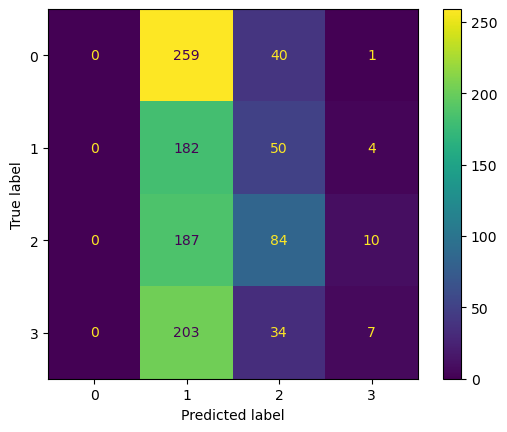

In [439]:
import mord as mord
c = mord.LogisticAT()
c.fit(X_train.to_numpy(), y_train.to_numpy().ravel())
y_pred = c.predict(X_test.to_numpy())

cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import matthews_corrcoef
print("accuracy score: ", accuracy_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

<AxesSubplot:>

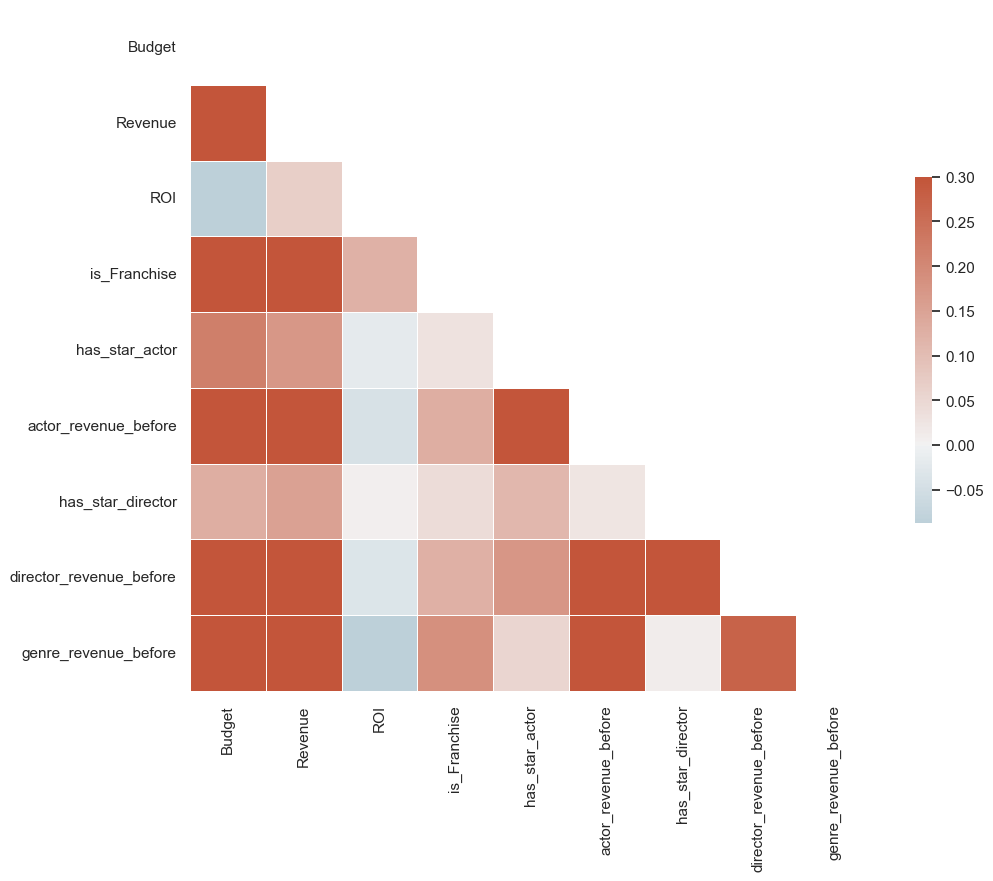

In [444]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = dataset.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
    timewindow_actor = s[0]
    timewindow_director = s[1]
    timewindow_genre = s[2]
    star_actor_num = s[3]
    star_director_num = s[4] 


    castinfo(timewindow_actor, star_actor_num)
    directorinfo(timewindow_director, star_director_num)
    genreinfo(timewindow_genre)

In [447]:
final.head(1)

,moviename,Budget,Revenue,ROI,Year,Month,Rating,Franchise,is_Franchise,Keywords,Genre,Production Method,Creative Type,Production/Financing Companies,Leading Cast,Director,has_star_actor,actor_revenue_before,has_star_director,director_revenue_before,hit,genre_revenue_before
0,The Super Mario Bros. Movie,100000000,"509,221,843.00",409.22,"2,023.00",April,PG,NaN,False,"['Ensemble', 'Prince/Princess', 'Royalty', 'Go...",Action,Digital Animation,Kids Fiction,"['Universal Pictures', 'Nintendo', 'Illuminati...","[Chris Pratt, Anya Taylor-Joy, Charlie Day, Ja...","[Aaron Horvath, Michael Jelenic]",True,14305072670,False,51620593,Hits,39962497649


<AxesSubplot:>

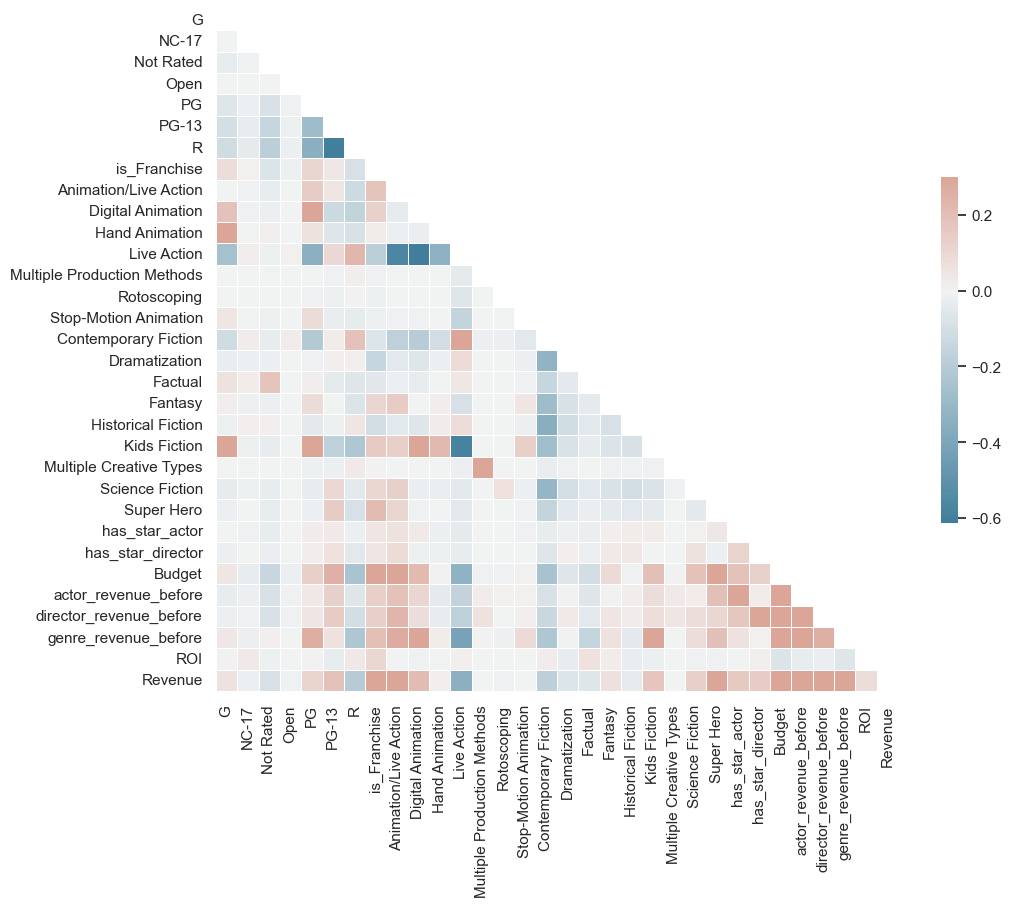

In [450]:
temp = pd.concat([
               pd.get_dummies(final['Rating']),
               final['is_Franchise'].astype(int),
               pd.get_dummies(final['Production Method']),
               pd.get_dummies(final['Creative Type']),
               final['has_star_actor'].astype(int),
               final['has_star_director'].astype(int),
               final[['Budget', 'actor_revenue_before', 'director_revenue_before',
        'genre_revenue_before', 'ROI', 'Revenue']].copy()
              ], axis = 1)



# Compute the correlation matrix
corr = temp.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
revenue ~ everything
revenue-budget ~ everything [-budget]

regression 
tree 


In [459]:
dataset['Revenue'].describe()

count           5,571.00
mean      105,564,648.67
std       193,366,119.52
min               527.00
25%        10,008,007.50
50%        37,226,218.00
75%       113,439,644.50
max     2,923,706,026.00
Name: Revenue, dtype: float64

C:\ProgramData\Anaconda3_new\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


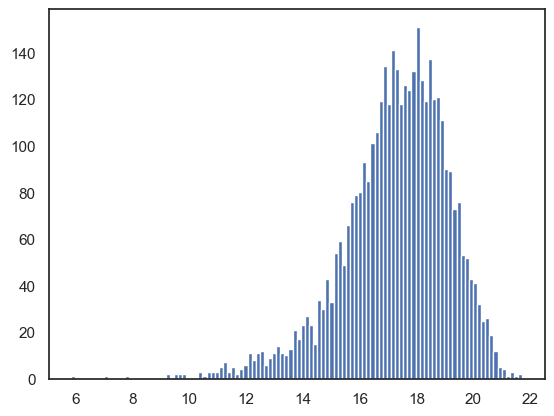

In [456]:
plt.hist(np.log(dataset['Revenue']-dataset['Budget']), bins = 110)
plt.show()

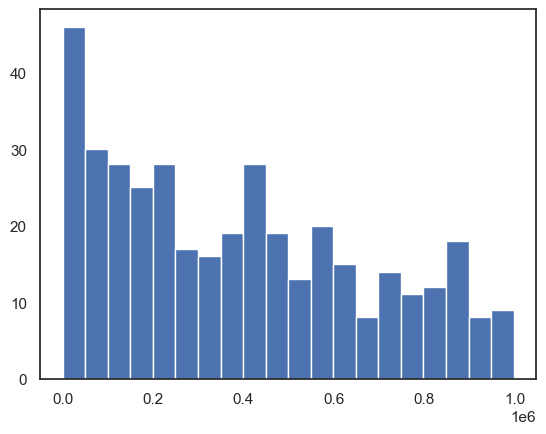

In [462]:
plt.hist(dataset.loc[dataset['Revenue'] < 1000000]['Revenue'], bins = 20)
plt.show()
zero inflated negative binomial/possion